# NBA Daily Fantasy Sports Analysis
**By: Zack Fort**

**Background** 
<br><br>
This analysis is in accordance with a free weekly Daily Fantasy NBA Basketball competition hosted by Yahoo. <br>I have participated in this competition in the past and decided to utilize the competition to forecast/predict player's performances and optimizing a potential lineup based on those predictions. <br><br> This notebook walks through collection of NBA traditional and advanced statistics from NBA.com's Python API, correlation analysis of different advanced statistics on player performance, prediction analysis to find the most accurate forecast methods, regression modeling to generate predictions with a model for each position, and an optimization script to produce a lineup to utilize for a given DFS competition based on each player's position, cost to add to the lineup, and predicted fantasy points.

#### Import Needed Libraries
Pandas and Numpy used for data organization and manipulation <br>
Pulp utilized for optimization model <br>
NBA_API utilized for data collection <br>
Seaborn and Matplotlib used for correlation analysis heatmap <br>
Statsmodels used for regression modeling <br>
Re used for regular expression text manipulation

In [1]:
import pandas as pd
import numpy as np
from pulp import *
import nba_api
from nba_api.stats.endpoints import playergamelogs
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

C:\Users\zacha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Set Date Variable to Associate with Date of DFS Competition

In [2]:
dat = '12-19'

#### Utilize Data Set Repo from GitHub

In [3]:
file3 = ('https://github.com/ZTFisme/Data-Sets/blob/main/Player_Positions.xlsx?raw=true')
file4 = ('https://github.com/ZTFisme/Data-Sets/blob/main/Yahoo_DFS_Cost.xlsx?raw=true')

#### Load in Player Positions and Player DFS Cost datasets
**Cost Dataset:** Dataset manually pulled from Yahoo DFS website that contains each player's name, position and cost to include that player in the lineup. Each sheet in the Excel dataset is associated with the date of the competition, so the Date variable set above helps to uniquely identify the needed Excel sheet.<br> 
**Positions Dataset:** Dataset with all players' positions. Utilized to reference player positions for developing prediction models for each unique player position.

In [4]:
cost = pd.read_excel(file4, sheet_name = dat, header=0)
cost = cost[['PLAYER', 'POSITION', 'COST']]
positions = pd.read_excel(file3, sheet_name = 'Positions', header = 0)

#### Load Data from NBA.com API
Utilize the playergamelogs NBA.com API endpoint to access up-to-date traditional and advanced player boxscores and load the datasets into dataframes.

In [5]:
trad_logs = pd.DataFrame() 
advanced_logs = pd.DataFrame()
    
tradlog = playergamelogs.PlayerGameLogs( season_nullable= '2021-22', measure_type_player_game_logs_nullable = nba_api.stats.library.parameters.MeasureTypePlayerGameLogs.base)
tlogs = tradlog.get_data_frames()[0]
trad_logs = trad_logs.append(tlogs)

advlogs = playergamelogs.PlayerGameLogs(season_nullable= '2021-22', measure_type_player_game_logs_nullable = nba_api.stats.library.parameters.MeasureTypePlayerGameLogs.advanced)
alogs = advlogs.get_data_frames()[0]
advanced_logs = advanced_logs.append(alogs)

Data Manipulation and 

In [6]:
adv_col = ['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'REB_PCT', 
       'EFG_PCT', 'TS_PCT', 'USG_PCT', 'PACE', 'PIE']
trad_col = ['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS']
advanced_logs = advanced_logs[adv_col]
trad_logs = trad_logs[trad_col]
trad = trad_logs.drop_duplicates().reset_index(drop=True)
adv = advanced_logs.drop_duplicates().reset_index(drop=True)

In [7]:
HA_lst = []
opp_lst = []
for i in range(len(trad)):
    game = trad.iloc[i]['MATCHUP']
    if '@' in game:
        HA_lst.append("Away")
        team, opp = game.split(' @ ')
        opp_lst.append(opp)
    else:
        HA_lst.append("Home")
        team, opp = game.split(' vs. ')
        opp_lst.append(opp)
trad['H_A'] = HA_lst
trad['OPP'] = opp_lst
trad = trad.merge(positions, left_on='PLAYER_NAME', right_on='PLAYER')

ha_lst= []
for i in range(len(trad)):
    if trad.iloc[i]['H_A'] == 'Home':
        ha_lst.append(1)
    else:
        ha_lst.append(0)
trad['HOME_AWAY'] = ha_lst
data = trad.merge(adv, how='right', on=['GAME_ID','TEAM_ID','PLAYER_ID'], suffixes=('', '_drop'))
data.drop([col for col in data.columns if 'drop' in col], axis=1, inplace=True)
data = data.dropna().drop_duplicates().reset_index(drop=True).rename(columns = {'NBA_FANTASY_PTS':'FPTS'})
data = data[data['MIN']!=0].reset_index(drop=True).rename(columns = {'TEAM_ABBREVIATION':'TEAM'})

data = data.sort_values(by=['PLAYER','GAME_DATE']).reset_index(drop=True)

#### Find and Utilize Best Forecasting Method/s
Compare different EMA and SMA values to find best MAD for general forecasts of different advanced statistics for modeling

In [8]:
tab = pd.DataFrame(columns = ['Type','K-Value', 'RSFE', 'ME', 'MAD', 'MSD', 'TS'])

for k in range(2,11):
    forecast = data.groupby('PLAYER')['FPTS'].transform(lambda x: x.rolling(k,k).mean()).shift(1)
    E = (data['FPTS'] - forecast)
    MAD = (forecast - data['FPTS']).abs()
    MSD = (forecast - data['FPTS']).abs().pow(2)
    tab.at[k-1, 'Type'] = 'SMA'
    tab.at[k-1, 'K-Value'] = k
    tab.at[k-1, 'RSFE'] = E.sum(skipna=True)
    tab.at[k-1, 'ME'] = np.nanmean(E)
    tab.at[k-1, 'MAD'] = np.nanmean(MAD)
    tab.at[k-1, 'MSD'] = np.nanmean(MSD)
    tab.at[k-1, 'TS'] = E.sum(skipna=True) / MAD.mean()
    
    ema = (data.groupby(['PLAYER'])['FPTS'].transform(lambda x: x.ewm(span=k,min_periods=k,adjust=False,ignore_na=False).mean())).shift(1) 
    ema_E = (data['FPTS'] - ema)
    ema_MAD = (ema - data['FPTS']).abs()
    ema_MSD = (ema - data['FPTS']).abs().pow(2)
    tab.at[k+9, 'Type'] = 'EMA'
    tab.at[k+9, 'K-Value'] = k
    tab.at[k+9, 'RSFE'] = ema_E.sum(skipna=True)
    tab.at[k+9, 'ME'] = np.nanmean(ema_E)
    tab.at[k+9, 'MAD'] = np.nanmean(ema_MAD)
    tab.at[k+9, 'MSD'] = np.nanmean(ema_MSD)
    tab.at[k+9, 'TS'] = ema_E.sum(skipna=True) / np.nanmean(ema_MAD)
print ('\033[1m' + 'Moving Average Forecasts:\n')
tab.sort_values(by='MAD',ascending=True).reset_index(drop=True)

Moving Average Forecasts:



,Type,K-Value,RSFE,ME,MAD,MSD,TS
0,EMA,6,1417.14,0.196253,8.03809,111.07,176.303
1,EMA,5,1457.12,0.190424,8.0414,111.433,181.203
2,EMA,7,1241.46,0.182622,8.0543,111.215,154.137
3,SMA,5,1723.54,0.22524,8.06512,111.569,213.703
4,SMA,6,1693.12,0.234471,8.0743,111.525,209.692
5,SMA,7,1527.53,0.224703,8.07887,111.896,189.077
6,EMA,8,1146.68,0.179786,8.08709,112.025,141.791
7,EMA,4,1203.2,0.148763,8.09813,112.951,148.577
8,EMA,9,1262.48,0.211683,8.12384,112.785,155.404
9,SMA,8,1424.05,0.223275,8.12432,112.643,175.282


Compare different alpha values of EWM and compare to above table for best forecast of individual player's fantasy points

In [9]:
tab = pd.DataFrame(columns = ['a-Value', 'RSFE', 'ME', 'MAD', 'MSD', 'TS'])
a_lst = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for a in range(len(a_lst)):
    forecast = (data.groupby(['PLAYER'])['FPTS'].transform(lambda x: x.ewm(alpha = a_lst[a], adjust=False,ignore_na=False).mean())).shift(1) 
    E = (data['FPTS'] - forecast)
    MAD = (forecast - data['FPTS']).abs()
    MSD = (forecast - data['FPTS']).abs().pow(2)
    tab.at[a-1, 'a-Value'] = a_lst[a]
    tab.at[a-1, 'RSFE'] = E.sum(skipna=True)
    tab.at[a-1, 'ME'] = np.nanmean(E)
    tab.at[a-1, 'MAD'] = np.nanmean(MAD)
    tab.at[a-1, 'MSD'] = np.nanmean(MSD)
    tab.at[a-1, 'TS'] = E.sum(skipna=True) / MAD.mean()
tab.sort_values(by='MAD',ascending=True).reset_index(drop=True)

,a-Value,RSFE,ME,MAD,MSD,TS
0,0.2,2372.65,0.251447,7.88636,108.126,300.856
1,0.3,1663.46,0.176288,7.92915,109.387,209.79
2,0.4,1189.01,0.126007,8.06028,112.929,147.514
3,0.1,3459.39,0.366616,8.09961,113.508,427.106
4,0.5,849.233,0.0899993,8.24581,117.861,102.99
5,0.6,591.866,0.0627243,8.47067,123.965,69.8724
6,0.7,388.899,0.0412143,8.72746,131.257,44.5603
7,0.8,224.132,0.0237528,9.01853,139.89,24.8523
8,0.9,87.3103,0.00925289,9.35354,150.14,9.33446


Utilize best EMA/SMA and k-value found in first table for forecasting advanced stats to utilize for modeling

In [10]:
data['EWM'] = (data.groupby(['PLAYER'])['FPTS'].transform(lambda x: x.ewm(alpha = 0.2, adjust=False,ignore_na=False).mean()))
data['FPTS/MIN'] = data['FPTS'] / data ['MIN']
data['MIN_EWM'] = (data.groupby(['PLAYER'])['MIN'].transform(lambda x: x.ewm(span=5,min_periods=5,adjust=False,ignore_na=False).mean()))
data['USG_PCT_EWM'] = (data.groupby(['PLAYER'])['USG_PCT'].transform(lambda x: x.ewm(span=5,min_periods=5,adjust=False,ignore_na=False).mean()))
data['REB_PCT_EWM'] = (data.groupby(['PLAYER'])['REB_PCT'].transform(lambda x: x.ewm(span=5,min_periods=5,adjust=False,ignore_na=False).mean()))
data['AST_PCT_EWM'] = (data.groupby(['PLAYER'])['AST_PCT'].transform(lambda x: x.ewm(span=5,min_periods=5,adjust=False,ignore_na=False).mean()))
data['TS_PCT_EWM'] = (data.groupby(['PLAYER'])['TS_PCT'].transform(lambda x: x.ewm(span=5,min_periods=5,adjust=False,ignore_na=False).mean()))
data['PIE_EWM'] = (data.groupby(['PLAYER'])['PIE'].transform(lambda x: x.ewm(span=5,min_periods=5,adjust=False,ignore_na=False).mean()))

player_stats = pd.DataFrame(data.groupby('PLAYER')['FPTS','FPTS/MIN'].mean())
last = pd.DataFrame(data.set_index('PLAYER').groupby(level='PLAYER').agg(['last']).stack())
last = last.reset_index()[['PLAYER','POSITION','TEAM','EWM']]
l = last.merge(player_stats, how='inner', left_on = 'PLAYER', right_on = 'PLAYER').rename(columns={'FPTS':'AVG_FPTS'})
l_avg = l[['PLAYER','AVG_FPTS']]
data = data.merge(l_avg)
data['PTS_DIFF'] = data['FPTS'] - data['AVG_FPTS']
data['PTS_DIFF_EWM'] = (data.groupby(['PLAYER'])['PTS_DIFF'].transform(lambda x: x.ewm(span=5,min_periods=5,adjust=False,ignore_na=False).mean()))

data = data.dropna().sort_values(by=['PLAYER_NAME','GAME_DATE']).reset_index(drop=True)

C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


Correlation Analysis between Fantasy Points and potential modeling statistics

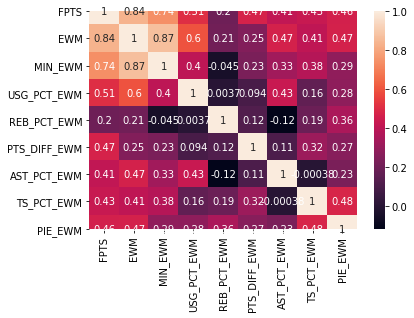

In [11]:
col_lst = ['FPTS', 'EWM', 'MIN_EWM', 'USG_PCT_EWM', 'REB_PCT_EWM', 'PTS_DIFF_EWM', 'AST_PCT_EWM',  'TS_PCT_EWM', 'PIE_EWM']
Cor_matrix = data[col_lst].corr()
sn.heatmap(Cor_matrix, annot=True)
plt.show()

Update Positions to player positions found on Yahoo DFS if needed

In [12]:
new_pos = cost[['PLAYER', 'POSITION']].rename(columns={'POSITION':'POSITION_new'})
new_pos = positions.merge(new_pos, how = 'left', left_on = 'POSITION', right_on = 'POSITION_new', suffixes=('', '_drop'))
new_pos.drop([col for col in new_pos.columns if 'drop' in col], axis=1, inplace=True)
new_pos = new_pos.drop_duplicates().reset_index(drop=True)
if len(new_pos[new_pos['POSITION']!= new_pos['POSITION_new']]) > 0:
    new_pos.drop(columns='POSITION')
    new_pos = new_pos.rename(columns={'POSITION_new':'POSITION'})
    new_pos.to_excel('Documents/Player_Positions.xlsx')
    'Player Position document updated with new player positions!'
else:
    print('No player position updates this time!')

No player position updates this time!


Split dataset by player position prior to modeling

In [13]:
pg = data[data['POSITION']=='PG'].reset_index(drop = True).dropna()
sg = data[data['POSITION']=='SG'].reset_index(drop = True).dropna()
sf = data[data['POSITION']=='SF'].reset_index(drop = True).dropna()
pf = data[data['POSITION']=='PF'].reset_index(drop = True).dropna()
c = data[data['POSITION']=='C'].reset_index(drop = True).dropna()

Define and apply function to filter out statistics that have little to no correlation with a player's Fantasy Points by position

In [14]:
def cor_analysis(df):
    col_lst = ['FPTS', 'EWM', 'MIN_EWM', 'USG_PCT_EWM', 'REB_PCT_EWM',
               'PTS_DIFF_EWM', 'AST_PCT_EWM',  'TS_PCT_EWM', 'PIE_EWM']
    var_lst = []

    Cor_matrix = df[col_lst].corr()
    #sn.heatmap(Cor_matrix, annot=True)
    #plt.show()
    datum = Cor_matrix['FPTS'].sort_values()[::-1][1:]

    for i in range(1,len(col_lst)):
        var = col_lst[i]
        #print(pg[var])
        if datum[var] > 0.4:
            var_lst.append(var)
        else:
            pass
    return var_lst

pg_vars = cor_analysis(pg)
sg_vars = cor_analysis(sg)
sf_vars = cor_analysis(sf)
pf_vars = cor_analysis(pf)
c_vars = cor_analysis(c)

Perform regression least-squares modeling and get intercept and different variables from model by position

In [15]:
def regression_predictions(data, var_lst):
    X = data[var_lst]
    y = data['FPTS']

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    pars = est2.params

    d = {}
    d['intercept'] = pars['const']
    for i in range(len(var_lst)):
        d[var_lst[i]] = pars[var_lst[i]]
    
    return d

pg_params = regression_predictions(pg, pg_vars)
sg_params = regression_predictions(sg, sg_vars)
sf_params = regression_predictions(sf, sf_vars)
pf_params = regression_predictions(pf, pf_vars)
c_params = regression_predictions(c, c_vars)

Utilize parameters by position to make predictions on the dataset based on the latest data on each player (last row for each player) and combine prediction datasets into single dataframe.

In [16]:
def make_predictions(data, params):
    incpt = params['intercept']
    if 'MIN_EWM' in params.keys():
        min_coef = params['MIN_EWM']
    else:
        min_coef = 0
        
    if 'EWM' in params.keys():
        ewm_coef = params['EWM']
    else:
        ewm_coef = 0    
    
    if 'USG_PCT_EWM' in params.keys():
        usg_coef = params['USG_PCT_EWM']
    else:
        usg_coef = 0  
    
    if 'PTS_DIFF_EWM' in params.keys():
        pts_diff_coef = params['PTS_DIFF_EWM']
    else:
        pts_diff_coef = 0
    
    if 'AST_PCT_EWM' in params.keys():
        ast_pct_coef = params['AST_PCT_EWM']
    else:
        ast_pct_coef = 0
    
    if 'TS_PCT_EWM' in params.keys():
        ts_pct_coef = params['TS_PCT_EWM']
    else:
        ts_pct_coef = 0
    
    if 'PIE_EWM' in params.keys():
        pie_coef = params['PIE_EWM']
    else:
        pie_coef = 0
    
    if 'REB_PCT_EWM' in params.keys():
        reb_pct_coef = params['REB_PCT_EWM']
    else:
        reb_pct_coef = 0
    
    predict = (incpt + (min_coef * data['MIN_EWM']) + (ewm_coef * data['EWM']) + (usg_coef * data['USG_PCT_EWM']) + (pts_diff_coef * data['PTS_DIFF_EWM']) + (ast_pct_coef * data['AST_PCT_EWM']) 
               + (ts_pct_coef * data['TS_PCT_EWM']) + (pie_coef * data['PIE_EWM']) + (reb_pct_coef * data['REB_PCT_EWM']))
    data['PRED'] = predict
    return data
pred = pd.DataFrame(data.set_index('PLAYER').groupby(level='PLAYER').agg(['last']).stack()).reset_index()[['PLAYER','POSITION','TEAM','EWM', 'AVG_FPTS', 'MIN_EWM', 'USG_PCT_EWM', 'PTS_DIFF_EWM', 'REB_PCT_EWM', 'AST_PCT_EWM',  'TS_PCT_EWM','PIE_EWM']]

pred_pg = pred[pred['POSITION']=='PG']
pred_pg = make_predictions(pred_pg, pg_params)

pred_sg = pred[pred['POSITION']=='SG']
pred_sg = make_predictions(pred_sg, sg_params)

pred_sf = pred[pred['POSITION']=='SF']
pred_sf = make_predictions(pred_sf, sf_params)

pred_pf = pred[pred['POSITION']=='PF']
pred_pf = make_predictions(pred_pf, pf_params)

pred_c = pred[pred['POSITION']=='C']
pred_c = make_predictions(pred_c, c_params)

pdList = [pred_pg, pred_sg, pred_sf, pred_pf, pred_c] 
pred = pd.concat(pdList)

C:\Users\zacha\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Combine predictions dataset with Yahoo DFS cost dataset to get positions, predictions and cost for each player in a single dataset

In [17]:
pred = pred.merge(cost, how = 'inner', left_on = 'PLAYER', right_on = 'PLAYER')
pred = pred.drop(columns = ["POSITION_x"]).rename(columns = {"POSITION_y":"POSITION"})
player_lst = []
for i in range(len(pred)):
    player_lst.append(re.sub('-',' ',pred['PLAYER'][i]))
pred['PLAYER'] = player_lst
pred = pred.round(2)

Utilize an optimization model with Pulp to generate an optimal lineup based on the prediction, position and cost for each player

In [18]:
df = pred
def pg_id(x):
    if x=='PG':
        return 1
    else:
        return 0
def sg_id(x):
    if x=='SG':
        return 1
    else:
        return 0
def sf_id(x):
    if x=='SF':
        return 1
    else:
        return 0
def pf_id(x):
    if x=='PF':
        return 1
    else:
        return 0
def c_id(x):
    if x=='C':
        return 1
    else:
        return 0

df['PG'] = df['POSITION'].apply(pg_id)
df['SG'] = df['POSITION'].apply(sg_id)
df['SF'] = df['POSITION'].apply(sf_id)
df['PF'] = df['POSITION'].apply(pf_id)
df['C'] = df['POSITION'].apply(c_id)
df['COST'] = [float(i) for i in df['COST']]

    #Clean data and convert to list- only look at rows with diet data and not constraint information
df = df.where(df['COST'] > 0)
df = df.dropna()
df = df.values.tolist()

players = [x[0] for x in df]
cost = dict([(x[0], float(x[13])) for x in df])
position = dict([(x[0], x[12]) for x in df])
proj_pts = dict([(x[0], float(x[11])) for x in df])

pg = dict([(x[0], float(x[14])) for x in df])
sg = dict([(x[0], float(x[15])) for x in df])
sf = dict([(x[0], float(x[16])) for x in df])
pf = dict([(x[0], float(x[17])) for x in df])
c = dict([(x[0], float(x[18])) for x in df])

player_vars = LpVariable.dicts("Player", players, cat = "Integer", lowBound= 0, upBound = 1)

    # create the optimization problem framework - maximize points while meeting requirements of maximum cost
prob = LpProblem("NBA_Optimize", LpMaximize)

    #Define objective function for projected points
obj_func = lpSum([proj_pts[i] * player_vars[i] for i in players])
prob += obj_func

    #Number of player choices constraint
constraint_2 = lpSum([player_vars[i] for i in player_vars]) == 8
prob += constraint_2 

    #Cost Constraint
constraint_3 = lpSum([cost[f] * player_vars[f] for f in player_vars]) <= 200.0
prob += constraint_3

    #Position Constraints
    #PG
prob += lpSum([pg[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([pg[f] * player_vars[f] for f in player_vars]) <= 3

    #SG
prob += lpSum([sg[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([sg[f] * player_vars[f] for f in player_vars]) <= 3

    #G
prob += lpSum([(pg[f] * player_vars[f]) + (sg[f] * player_vars[f]) for f in player_vars]) >= 3
prob += lpSum([(pg[f] * player_vars[f]) + (sg[f] * player_vars[f]) for f in player_vars]) <= 4

    #SF
prob += lpSum([sf[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([sf[f] * player_vars[f] for f in player_vars]) <= 3

    #PF
prob += lpSum([pf[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([pf[f] * player_vars[f] for f in player_vars]) <= 3

    #F
prob += lpSum([(sf[f] * player_vars[f]) + (pf[f] * player_vars[f]) for f in player_vars]) >= 3
prob += lpSum([(sf[f] * player_vars[f]) + (pf[f] * player_vars[f]) for f in player_vars]) <= 4

    #C
prob += lpSum([c[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([c[f] * player_vars[f] for f in player_vars]) <= 2

    #Solve the Objective Function
prob.solve()
name_lst = []
import re
for x in prob.variables():
    if x.varValue>0:
        nm = x.name
        name_lst.append(re.sub(r'[_]',' ',nm[7:]))
lineup = pd.DataFrame(name_lst).rename(columns={0:'PLAYER'})
lineup = lineup.merge(pred, how = 'inner', left_on = 'PLAYER', right_on = 'PLAYER')
lineup = lineup[['PLAYER', 'POSITION', 'EWM', 'PTS_DIFF_EWM', 'AVG_FPTS', 'COST', 'PRED']]
print('The Projected Total Points is: ', round(sum(lineup['PRED']),2))
print('The optimal lineup based on your predictions is: ')
lineup

The Projected Total Points is:  319.98
The optimal lineup based on your predictions is: 


,PLAYER,POSITION,EWM,PTS_DIFF_EWM,AVG_FPTS,COST,PRED
0,Damian Lillard,PG,43.50,6.21,39.72,38.0,48.71
1,Derrick White,SG,36.50,5.97,31.35,26.0,39.92
2,Gabe Vincent,PG,25.99,13.78,15.51,16.0,39.88
3,Karl Anthony Towns,C,46.27,4.98,43.52,40.0,49.09
4,Kyle Anderson,PF,27.23,6.36,22.82,16.0,32.40
5,Norman Powell,SF,30.65,6.33,26.48,23.0,36.87
6,P.J. Tucker,PF,26.45,7.79,20.11,15.0,35.30
7,Tyrese Haliburton,SG,34.38,5.25,31.32,25.0,37.81


### Analyze Predictions

**Top 15 Players based on Predicted Fantasy Points**

In [19]:
pred[['PLAYER', 'POSITION', 'EWM', 'MIN_EWM', 'REB_PCT_EWM', 'AST_PCT_EWM', 'USG_PCT_EWM', 'TS_PCT_EWM', 'PTS_DIFF_EWM', 'PIE_EWM', 'AVG_FPTS', 'COST', 'PRED']].sort_values('PRED', ascending = False).reset_index(drop = True).head(15)

,PLAYER,POSITION,EWM,MIN_EWM,REB_PCT_EWM,AST_PCT_EWM,USG_PCT_EWM,TS_PCT_EWM,PTS_DIFF_EWM,PIE_EWM,AVG_FPTS,COST,PRED
0,Karl Anthony Towns,C,46.27,33.83,0.11,0.18,0.29,0.64,4.98,0.17,43.52,40.0,49.09
1,LaMelo Ball,PG,47.94,33.61,0.10,0.37,0.29,0.64,2.89,0.15,45.21,45.0,48.72
2,Damian Lillard,PG,43.50,38.48,0.06,0.29,0.31,0.62,6.21,0.15,39.72,38.0,48.71
3,Kristaps Porzingis,PF,38.87,31.60,0.15,0.10,0.32,0.51,2.28,0.14,38.02,38.0,41.18
4,DeMar DeRozan,PF,40.79,36.62,0.08,0.17,0.29,0.61,0.81,0.15,40.68,38.0,41.01
5,Derrick White,SG,36.50,31.54,0.07,0.24,0.23,0.61,5.97,0.13,31.35,26.0,39.92
6,Gabe Vincent,PG,25.99,32.33,0.04,0.21,0.24,0.62,13.78,0.10,15.51,16.0,39.88
7,Chris Paul,PG,38.79,31.60,0.08,0.45,0.23,0.59,0.07,0.16,39.15,36.0,38.53
8,Kyle Lowry,PG,34.69,35.92,0.06,0.43,0.20,0.65,3.18,0.13,32.12,31.0,38.52
9,Miles Bridges,PF,38.04,36.27,0.11,0.25,0.19,0.57,1.34,0.12,38.35,34.0,38.22


**Top 15 Players Based on Value** <br>
Value is calculated as the Predicted Fantasy Points divided by the Cost to select that player in your lineup

In [20]:
pred['VALUE'] = round(pred['PRED'] / pred['COST'],2)
pred[['PLAYER', 'POSITION', 'EWM', 'MIN_EWM', 'REB_PCT_EWM', 'AST_PCT_EWM', 'USG_PCT_EWM', 'TS_PCT_EWM', 'PTS_DIFF_EWM', 'PIE_EWM', 'AVG_FPTS', 'COST', 'PRED','VALUE']].sort_values('VALUE', ascending = False).reset_index(drop=True).head(15)

,PLAYER,POSITION,EWM,MIN_EWM,REB_PCT_EWM,AST_PCT_EWM,USG_PCT_EWM,TS_PCT_EWM,PTS_DIFF_EWM,PIE_EWM,AVG_FPTS,COST,PRED,VALUE
0,Cameron Payne,PG,22.30,25.76,0.07,0.30,0.26,0.50,3.54,0.08,19.57,10.0,27.47,2.75
1,Tristan Thompson,C,19.31,20.49,0.17,0.08,0.22,0.60,5.04,0.11,15.86,10.0,25.23,2.52
2,Gabe Vincent,PG,25.99,32.33,0.04,0.21,0.24,0.62,13.78,0.10,15.51,16.0,39.88,2.49
3,Omer Yurtseven,C,14.28,15.55,0.20,0.17,0.20,0.50,8.25,0.12,8.08,10.0,24.59,2.46
4,Nassir Little,SF,21.32,28.05,0.10,0.13,0.13,0.47,3.14,0.08,19.65,10.0,24.07,2.41
5,P.J. Tucker,PF,26.45,33.01,0.08,0.17,0.16,0.64,7.79,0.11,20.11,15.0,35.30,2.35
6,Cameron Johnson,PF,23.42,29.58,0.10,0.06,0.17,0.71,4.63,0.11,18.95,12.0,28.23,2.35
7,Trey Burke,PG,17.20,18.52,0.05,0.30,0.28,0.53,8.27,0.11,12.31,12.0,27.35,2.28
8,Frank Jackson,SG,17.80,24.90,0.04,0.06,0.23,0.58,3.59,0.08,14.74,10.0,22.50,2.25
9,Max Strus,SF,19.00,24.35,0.08,0.10,0.19,0.59,6.90,0.11,15.23,12.0,26.87,2.24
